# SET UP

In [5]:
import os
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

import math
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.io as pio
import plotly.graph_objs as go
from plotly.subplots import make_subplots


from models import * 
from utils import * 

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

# EDA 

In [59]:
ID = '06DA002'
ClimateID = '1128958'
!wget https://dd.weather.gc.ca/hydrometric/csv/MB/daily/MB_05TD001_daily_hydrometric.csv
hydro = pd.read_csv('./MB_05TD001_daily_hydrometric.csv')

--2020-11-13 01:40:36--  https://dd.weather.gc.ca/hydrometric/csv/MB/daily/MB_05TD001_daily_hydrometric.csv
Resolving dd.weather.gc.ca (dd.weather.gc.ca)... 205.189.10.47
Connecting to dd.weather.gc.ca (dd.weather.gc.ca)|205.189.10.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 472087 (461K) [text/csv]
Saving to: ‘MB_05TD001_daily_hydrometric.csv’

MB_05TD001_daily_hy 100%[===================>] 461.02K   492KB/s    in 0.9s    

2020-11-13 01:40:38 (492 KB/s) - ‘MB_05TD001_daily_hydrometric.csv’ saved [472087/472087]



In [60]:
hydro.drop(hydro[hydro["Water Level / Niveau d'eau (m)"]==99999.009].index , inplace =True ) 
hydro["Water Level"] = hydro["Water Level / Niveau d'eau (m)"]
hydro["Date"] = pd.to_datetime(hydro["Date"])
hydro = hydro[["Date","Water Level"]]

## Stationarity 

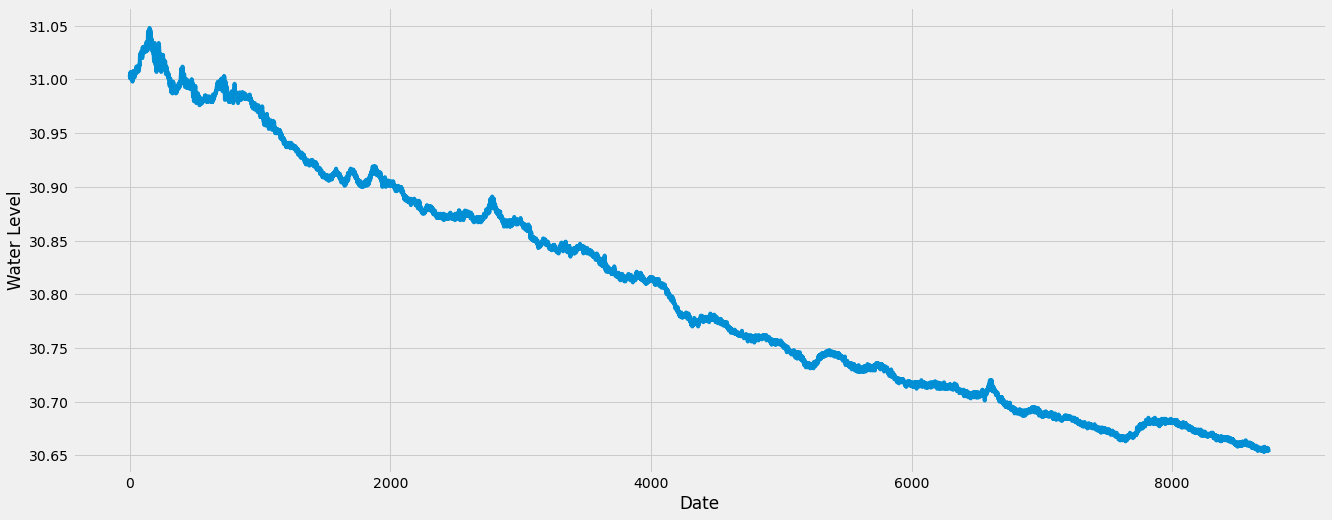

In [61]:
plt.xlabel("Date")
plt.ylabel("Water Level")
plt.plot(hydro["Water Level"])
plt.show()

in the time series forecasting, we search usually for a stationary series. The series should have a constant mean, variance, and covariance.

so let's check if the  Water Level series is stationary or not. to do this i will use ADF (Augmented Dickey-Fuller) Test :

* Null Hypothesis: The series has a unit root
* Alternate Hypothesis: The series has no unit root.


If we fail to reject the null hypothesis, we can say that the series is non-stationary.

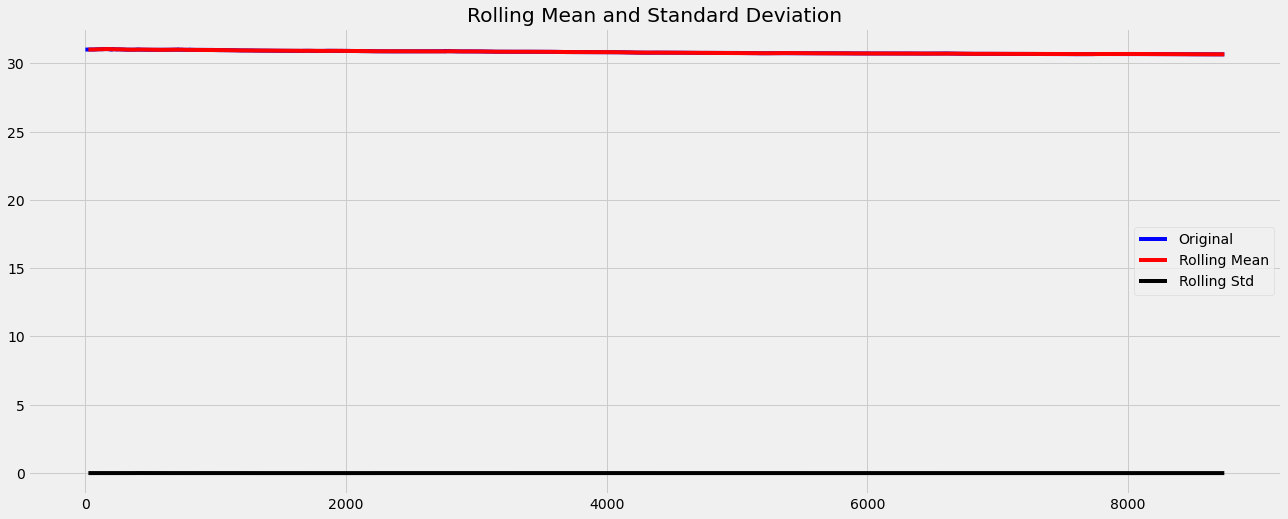

Results of dickey fuller test
Test Statistics                  -1.518328
p-value                           0.524426
No. of lags used                 27.000000
Number of observations used    8712.000000
critical value (1%)              -3.431101
critical value (5%)              -2.861872
critical value (10%)             -2.566947
dtype: float64


In [62]:
test_stationarity(hydro["Water Level"])

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

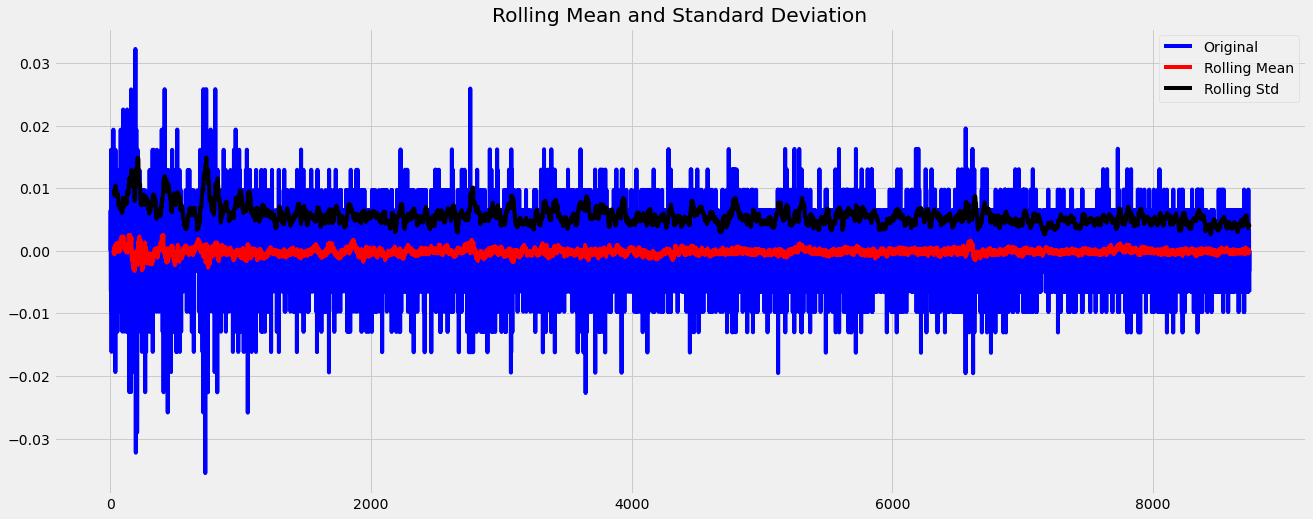

Results of dickey fuller test
Test Statistics               -1.744510e+01
p-value                        4.686084e-30
No. of lags used               2.600000e+01
Number of observations used    8.712000e+03
critical value (1%)           -3.431101e+00
critical value (5%)           -2.861872e+00
critical value (10%)          -2.566947e+00
dtype: float64


In [63]:
hydro['Water Level_previous'] = hydro["Water Level"].shift(1) 
hydro['WL_pct'] = 100*(hydro["Water Level"]  - hydro['Water Level_previous'] ) / hydro['Water Level_previous']
hydro.dropna(inplace = True)
test_stationarity(hydro['WL_pct'])

Through the above graph,The series have a constant mean and variance. and the p-value is less than 0.05 so we can reject the Null hypothesis. so the data is stationary.

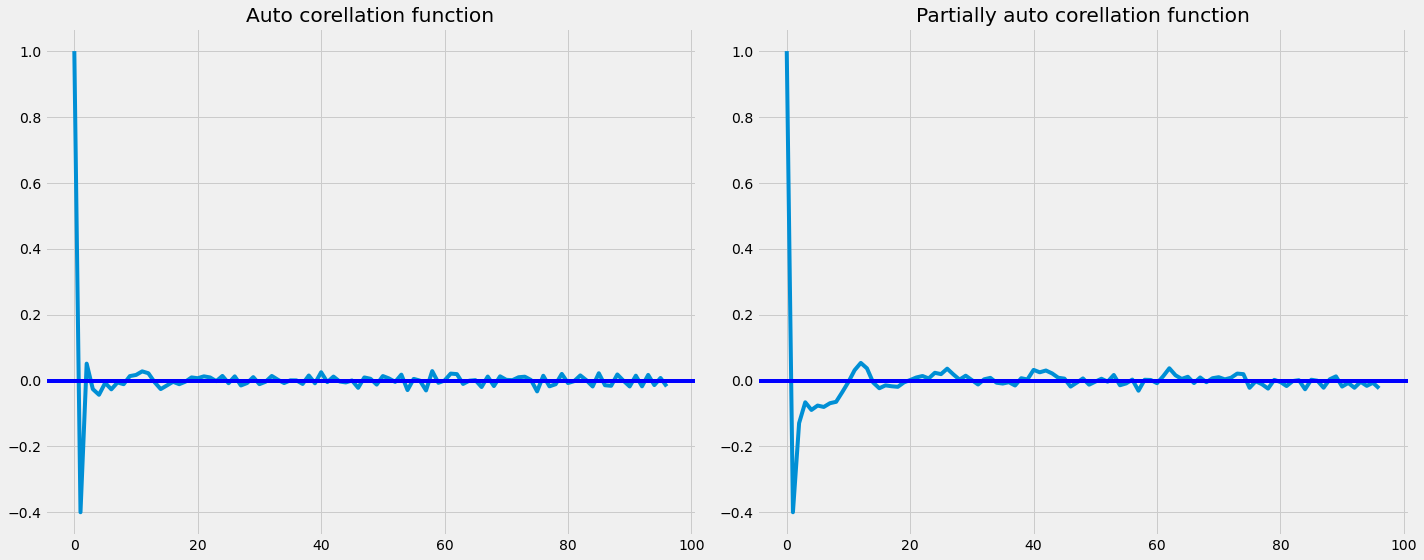

In [64]:
# we use d value here(data_log_shift)
_acf = acf(hydro['WL_pct'], nlags=96)
_pacf= pacf(hydro['WL_pct'], nlags=96,method='ols')
#plot PACF
plt.subplot(121)
plt.plot(_acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.title('Auto corellation function')
plt.tight_layout()
#plot ACF
plt.subplot(122)
plt.plot(_pacf) 
plt.axhline(y=0,linestyle='-',color='blue')

plt.title('Partially auto corellation function')
plt.tight_layout()

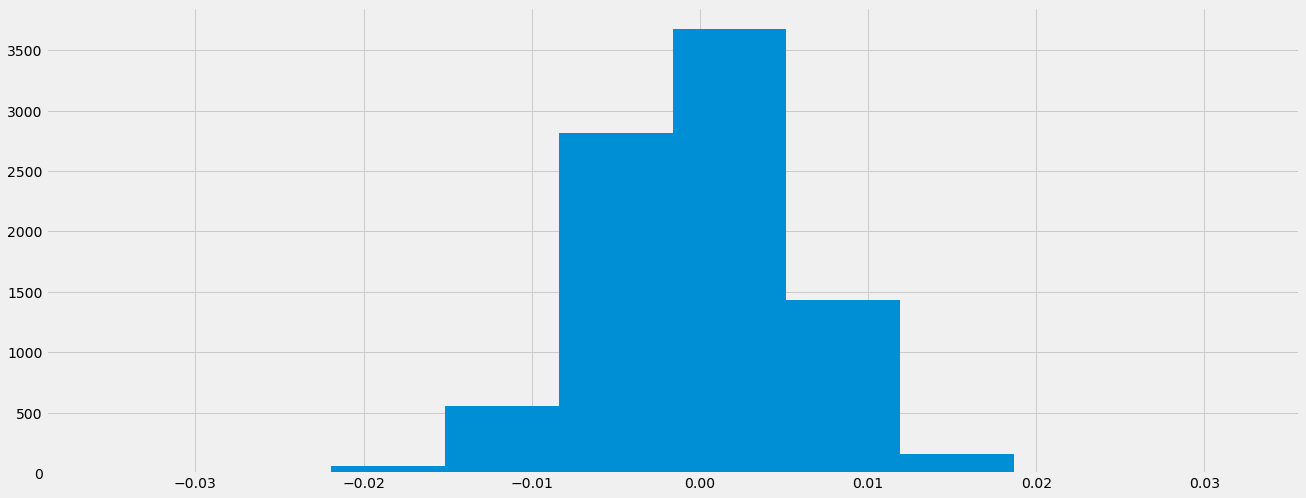

In [65]:
hydro['WL_pct'].hist()

## To Do:  multivarite Time Series Analysis

# To Do : Data Denoising

# Feature Engineering

## Statistical Features 

In [66]:
hydro['WL_mean_12'] = hydro['WL_pct'].rolling(12).mean()
hydro['WL_mean_18'] = hydro['WL_pct'].rolling(18).mean()
hydro['WL_mean_24'] = hydro['WL_pct'].rolling(24).mean()

hydro['WL_std_12']  = hydro['WL_pct'].rolling(12).std()
hydro['WL_std_24']  = hydro['WL_pct'].rolling(24).std()

hydro['WL_lag_12']  = hydro['WL_pct'].shift(12)
hydro['WL_lag_6']  = hydro['WL_pct'].shift(6)

hydro.dropna(inplace = True )

In [67]:
num_feat = ['WL_pct','WL_mean_12','WL_mean_18','WL_mean_18','WL_mean_24','WL_std_12','WL_std_24','WL_lag_12','WL_lag_6']

## Time Based Features 

In [68]:
hydro['hour'] = hydro['Date'].dt.hour
hydro['dayOfweek'] =  hydro['Date'].dt.dayofweek

In [69]:
cat_feat = ['hour','dayOfweek']

In [70]:
embbedded_size  = [(24,12),(7,4)]

# Modling Part 

In [ ]:
seq_len = len(hydro)
train_data = hydro.iloc[:int(0.8*seq_len)] 
val_data = hydro.iloc[int(0.8*seq_len):] 

## Model 1 :  Stacked LSTM 

In [75]:
# Hyperparameters 
train_batch_size = 32
valid_batch_size = 16
epochs = 100
input_size = len(num_feat)
hidden_size = 32
lr = 1e-5
device = torch.device('cuda')
window_size = 24  
path = 'LSTM_Staked.pth'

train_dataset = hydro_dataset(train_data , window_size , num_feat , cat_feat )
valid_dataset = hydro_dataset(val_data , window_size , num_feat , cat_feat )

model = StackedLSTMs(input_size,hidden_size)
model = model.to(device)
val_loss, train_loss = run(
    model,
    train_dataset,
    valid_dataset,
    lr,
    epochs,
    train_batch_size,
    valid_batch_size,
    device,
    path,
)

--------- Epoch 0 ---------


100%|██████████| 218/218 [00:03<00:00, 61.67it/s, loss=0.0192]

 train_loss  = 0.019198568435300382



100%|██████████| 108/108 [00:01<00:00, 100.55it/s, loss=0.0157]


 val_loss  = 0.015658583172976418
--------- Epoch 1 ---------


100%|██████████| 218/218 [00:03<00:00, 64.53it/s, loss=0.0125]

 train_loss  = 0.012518992762875939



100%|██████████| 108/108 [00:00<00:00, 116.66it/s, loss=0.00947]

 val_loss  = 0.00946856106855665
--------- Epoch 2 ---------



100%|██████████| 218/218 [00:03<00:00, 64.07it/s, loss=0.00684]

 train_loss  = 0.006830195783116265



100%|██████████| 108/108 [00:00<00:00, 114.17it/s, loss=0.00437]


 val_loss  = 0.0043676961234908685
--------- Epoch 3 ---------


100%|██████████| 218/218 [00:04<00:00, 53.17it/s, loss=0.00258]

 train_loss  = 0.002575510303776096



100%|██████████| 108/108 [00:00<00:00, 115.49it/s, loss=0.00118]

 val_loss  = 0.0011775201859968042
--------- Epoch 4 ---------



100%|██████████| 218/218 [00:03<00:00, 64.13it/s, loss=0.000563]

 train_loss  = 0.00056199245377809



100%|██████████| 108/108 [00:01<00:00, 106.35it/s, loss=0.000259]


 val_loss  = 0.00025783663522815914
--------- Epoch 5 ---------


100%|██████████| 218/218 [00:03<00:00, 58.06it/s, loss=0.000182]

 train_loss  = 0.0001818234875393442



100%|██████████| 108/108 [00:00<00:00, 115.25it/s, loss=0.000147]


 val_loss  = 0.00014655248796097348
--------- Epoch 6 ---------


100%|██████████| 218/218 [00:03<00:00, 63.40it/s, loss=0.00012] 

 train_loss  = 0.00011983276859492944



100%|██████████| 108/108 [00:00<00:00, 117.91it/s, loss=0.000101]


 val_loss  = 0.00010098811184501824
--------- Epoch 7 ---------


100%|██████████| 218/218 [00:03<00:00, 59.03it/s, loss=8.98e-5]

 train_loss  = 8.987061436186062e-05



100%|██████████| 108/108 [00:00<00:00, 114.76it/s, loss=7.6e-5] 

 val_loss  = 7.592514122768114e-05
--------- Epoch 8 ---------



100%|██████████| 218/218 [00:03<00:00, 63.08it/s, loss=7.31e-5]

 train_loss  = 7.300815692243814e-05



100%|██████████| 108/108 [00:01<00:00, 85.26it/s, loss=6.17e-5] 


 val_loss  = 6.154889506938666e-05
--------- Epoch 9 ---------


100%|██████████| 218/218 [00:03<00:00, 60.13it/s, loss=6.34e-5]

 train_loss  = 6.315924704079933e-05



100%|██████████| 108/108 [00:01<00:00, 55.44it/s, loss=5.23e-5]


 val_loss  = 5.217026659078396e-05
--------- Epoch 10 ---------


100%|██████████| 218/218 [00:03<00:00, 61.45it/s, loss=5.72e-5]

 train_loss  = 5.7061439951913274e-05



100%|██████████| 108/108 [00:00<00:00, 114.54it/s, loss=4.61e-5]


 val_loss  = 4.6014786095030206e-05
--------- Epoch 11 ---------


100%|██████████| 218/218 [00:03<00:00, 64.73it/s, loss=5.28e-5]

 train_loss  = 5.2626024459199254e-05



100%|██████████| 108/108 [00:01<00:00, 90.38it/s, loss=4.15e-5]


 val_loss  = 4.143810891340157e-05
--------- Epoch 12 ---------


100%|██████████| 218/218 [00:03<00:00, 63.93it/s, loss=4.96e-5]

 train_loss  = 4.947031811752822e-05



100%|██████████| 108/108 [00:00<00:00, 113.35it/s, loss=3.8e-5] 


 val_loss  = 3.792408511395074e-05
--------- Epoch 13 ---------


100%|██████████| 218/218 [00:03<00:00, 64.62it/s, loss=4.7e-5] 

 train_loss  = 4.68122984409234e-05



100%|██████████| 108/108 [00:00<00:00, 114.42it/s, loss=3.51e-5]


 val_loss  = 3.5031859262609806e-05
--------- Epoch 14 ---------


100%|██████████| 218/218 [00:03<00:00, 59.55it/s, loss=4.49e-5]

 train_loss  = 4.482290200481123e-05



100%|██████████| 108/108 [00:00<00:00, 117.87it/s, loss=3.29e-5]


 val_loss  = 3.2868127222913984e-05
--------- Epoch 15 ---------


100%|██████████| 218/218 [00:03<00:00, 63.91it/s, loss=4.31e-5]

 train_loss  = 4.301516847849056e-05



100%|██████████| 108/108 [00:00<00:00, 116.53it/s, loss=3.1e-5] 

 val_loss  = 3.087321478974277e-05
--------- Epoch 16 ---------



100%|██████████| 218/218 [00:03<00:00, 54.97it/s, loss=4.18e-5]

 train_loss  = 4.198881829700298e-05



100%|██████████| 108/108 [00:01<00:00, 98.72it/s, loss=2.93e-5]


 val_loss  = 2.9256471306224637e-05
--------- Epoch 17 ---------


100%|██████████| 218/218 [00:03<00:00, 61.95it/s, loss=4.04e-5]

 train_loss  = 4.040977397180374e-05



100%|██████████| 108/108 [00:00<00:00, 110.63it/s, loss=2.81e-5]


 val_loss  = 2.800462033081675e-05
--------- Epoch 18 ---------


100%|██████████| 218/218 [00:03<00:00, 58.54it/s, loss=3.92e-5]

 train_loss  = 3.9048936616732424e-05



100%|██████████| 108/108 [00:01<00:00, 100.91it/s, loss=2.67e-5]


 val_loss  = 2.668401107594373e-05
--------- Epoch 19 ---------


100%|██████████| 218/218 [00:03<00:00, 63.01it/s, loss=3.82e-5]

 train_loss  = 3.814259414015596e-05



100%|██████████| 108/108 [00:00<00:00, 117.15it/s, loss=2.57e-5]


 val_loss  = 2.564221715686101e-05
--------- Epoch 20 ---------


100%|██████████| 218/218 [00:03<00:00, 64.85it/s, loss=3.73e-5]

 train_loss  = 3.718601862743493e-05



100%|██████████| 108/108 [00:01<00:00, 86.53it/s, loss=2.49e-5]


 val_loss  = 2.489295426736741e-05
--------- Epoch 21 ---------


100%|██████████| 218/218 [00:03<00:00, 54.77it/s, loss=3.64e-5]

 train_loss  = 3.630000305288752e-05



100%|██████████| 108/108 [00:01<00:00, 105.86it/s, loss=2.41e-5]


 val_loss  = 2.400432988367727e-05
--------- Epoch 22 ---------


100%|██████████| 218/218 [00:03<00:00, 61.17it/s, loss=3.57e-5]

 train_loss  = 3.569424083202606e-05



100%|██████████| 108/108 [00:00<00:00, 112.48it/s, loss=2.34e-5]


 val_loss  = 2.332123431693213e-05
--------- Epoch 23 ---------


100%|██████████| 218/218 [00:04<00:00, 52.53it/s, loss=3.5e-5] 

 train_loss  = 3.5073910358407555e-05



100%|██████████| 108/108 [00:00<00:00, 113.93it/s, loss=2.28e-5]


 val_loss  = 2.2769893597022155e-05
--------- Epoch 24 ---------


100%|██████████| 218/218 [00:03<00:00, 63.27it/s, loss=3.46e-5]

 train_loss  = 3.4750384535957415e-05



100%|██████████| 108/108 [00:00<00:00, 115.50it/s, loss=2.23e-5]


 val_loss  = 2.2272741236722344e-05
--------- Epoch 25 ---------


100%|██████████| 218/218 [00:03<00:00, 59.47it/s, loss=3.41e-5]

 train_loss  = 3.408981198820108e-05



100%|██████████| 108/108 [00:00<00:00, 114.99it/s, loss=2.22e-5]


 val_loss  = 2.2158414527371793e-05
--------- Epoch 26 ---------


100%|██████████| 218/218 [00:03<00:00, 64.72it/s, loss=3.36e-5]

 train_loss  = 3.3541926455621525e-05



100%|██████████| 108/108 [00:00<00:00, 116.21it/s, loss=2.13e-5]


 val_loss  = 2.130351347457488e-05
--------- Epoch 27 ---------


100%|██████████| 218/218 [00:03<00:00, 62.45it/s, loss=3.32e-5]

 train_loss  = 3.3216331528552856e-05



100%|██████████| 108/108 [00:01<00:00, 102.90it/s, loss=2.1e-5] 


 val_loss  = 2.0944851232545465e-05
--------- Epoch 28 ---------


100%|██████████| 218/218 [00:03<00:00, 64.43it/s, loss=3.29e-5]

 train_loss  = 3.2758509401367375e-05



100%|██████████| 108/108 [00:00<00:00, 112.71it/s, loss=2.08e-5]


 val_loss  = 2.082612593733723e-05
--------- Epoch 29 ---------


100%|██████████| 218/218 [00:03<00:00, 64.10it/s, loss=3.25e-5]

 train_loss  = 3.260222267038552e-05



100%|██████████| 108/108 [00:00<00:00, 113.67it/s, loss=2.03e-5]


 val_loss  = 2.0300725762151866e-05
--------- Epoch 30 ---------


100%|██████████| 218/218 [00:04<00:00, 53.20it/s, loss=3.23e-5]

 train_loss  = 3.2287397370464114e-05



100%|██████████| 108/108 [00:00<00:00, 116.21it/s, loss=2.01e-5]


 val_loss  = 2.00752741016509e-05
--------- Epoch 31 ---------


100%|██████████| 218/218 [00:03<00:00, 64.84it/s, loss=3.2e-5] 

 train_loss  = 3.1871086513100795e-05



100%|██████████| 108/108 [00:00<00:00, 114.58it/s, loss=2e-5]   


 val_loss  = 1.998652898557204e-05
--------- Epoch 32 ---------


100%|██████████| 218/218 [00:03<00:00, 59.70it/s, loss=3.16e-5]


 train_loss  = 3.16372632561078e-05


100%|██████████| 108/108 [00:00<00:00, 114.34it/s, loss=1.97e-5]


 val_loss  = 1.968809883018602e-05
--------- Epoch 33 ---------


100%|██████████| 218/218 [00:04<00:00, 51.86it/s, loss=3.14e-5]

 train_loss  = 3.1379234698777827e-05



100%|██████████| 108/108 [00:00<00:00, 112.32it/s, loss=1.95e-5]


 val_loss  = 1.9448309499407684e-05
--------- Epoch 34 ---------


100%|██████████| 218/218 [00:03<00:00, 56.66it/s, loss=3.12e-5]


 train_loss  = 3.107900889984886e-05


100%|██████████| 108/108 [00:01<00:00, 107.57it/s, loss=1.93e-5]


 val_loss  = 1.9286688501341376e-05
--------- Epoch 35 ---------


100%|██████████| 218/218 [00:03<00:00, 64.17it/s, loss=3.11e-5]

 train_loss  = 3.129676894928674e-05



100%|██████████| 108/108 [00:00<00:00, 115.30it/s, loss=1.91e-5]

 val_loss  = 1.9068604000562186e-05
--------- Epoch 36 ---------



100%|██████████| 218/218 [00:03<00:00, 63.11it/s, loss=3.09e-5]

 train_loss  = 3.1039669540922486e-05



100%|██████████| 108/108 [00:01<00:00, 64.32it/s, loss=1.92e-5]

 val_loss  = 1.9153532632656237e-05
--------- Epoch 37 ---------



100%|██████████| 218/218 [00:03<00:00, 63.34it/s, loss=3.07e-5]

 train_loss  = 3.0700441705473644e-05



100%|██████████| 108/108 [00:00<00:00, 115.42it/s, loss=1.89e-5]


 val_loss  = 1.885090700347468e-05
--------- Epoch 38 ---------


100%|██████████| 218/218 [00:03<00:00, 64.92it/s, loss=3.06e-5]

 train_loss  = 3.056990694983701e-05



100%|██████████| 108/108 [00:01<00:00, 101.00it/s, loss=1.87e-5]


 val_loss  = 1.8691954736553912e-05
--------- Epoch 39 ---------


100%|██████████| 218/218 [00:03<00:00, 59.41it/s, loss=3.06e-5]

 train_loss  = 3.0501246349500235e-05



100%|██████████| 108/108 [00:00<00:00, 113.33it/s, loss=1.85e-5]


 val_loss  = 1.8532725979033177e-05
--------- Epoch 40 ---------


100%|██████████| 218/218 [00:03<00:00, 63.27it/s, loss=3.03e-5]

 train_loss  = 3.021252995778856e-05



100%|██████████| 108/108 [00:00<00:00, 113.67it/s, loss=1.89e-5]

 val_loss  = 1.8861525429909103e-05
--------- Epoch 41 ---------



100%|██████████| 218/218 [00:03<00:00, 60.29it/s, loss=3.03e-5]

 train_loss  = 3.0782859393593335e-05



100%|██████████| 108/108 [00:00<00:00, 114.71it/s, loss=1.84e-5]


 val_loss  = 1.8363773775760178e-05
--------- Epoch 42 ---------


100%|██████████| 218/218 [00:03<00:00, 64.16it/s, loss=3.01e-5]


 train_loss  = 3.0009787209514755e-05


100%|██████████| 108/108 [00:00<00:00, 114.77it/s, loss=1.83e-5]


 val_loss  = 1.833840353053044e-05
--------- Epoch 43 ---------


100%|██████████| 218/218 [00:03<00:00, 54.97it/s, loss=3.01e-5]

 train_loss  = 3.0175925785275933e-05



100%|██████████| 108/108 [00:01<00:00, 94.59it/s, loss=1.83e-5] 


 val_loss  = 1.8266498567822122e-05
--------- Epoch 44 ---------


100%|██████████| 218/218 [00:03<00:00, 64.15it/s, loss=3e-5]   

 train_loss  = 2.9938956590281498e-05



100%|██████████| 108/108 [00:00<00:00, 113.97it/s, loss=1.82e-5]

 val_loss  = 1.822444441283248e-05
--------- Epoch 45 ---------



100%|██████████| 218/218 [00:03<00:00, 55.83it/s, loss=3e-5]   

 train_loss  = 2.9900514502114342e-05



100%|██████████| 108/108 [00:01<00:00, 88.73it/s, loss=1.82e-5]

 val_loss  = 1.8142713892538502e-05
--------- Epoch 46 ---------



100%|██████████| 218/218 [00:03<00:00, 56.82it/s, loss=2.98e-5]

 train_loss  = 2.9751575295132513e-05



100%|██████████| 108/108 [00:00<00:00, 110.97it/s, loss=1.82e-5]


 val_loss  = 1.815989237793811e-05
--------- Epoch 47 ---------


100%|██████████| 218/218 [00:03<00:00, 61.84it/s, loss=2.98e-5]

 train_loss  = 2.982692084840708e-05



100%|██████████| 108/108 [00:01<00:00, 95.61it/s, loss=1.8e-5] 

 val_loss  = 1.7978062142329117e-05
--------- Epoch 48 ---------



100%|██████████| 218/218 [00:03<00:00, 62.36it/s, loss=2.96e-5]

 train_loss  = 2.9537190053031386e-05



100%|██████████| 108/108 [00:00<00:00, 111.04it/s, loss=1.79e-5]


 val_loss  = 1.7904702055467943e-05
--------- Epoch 49 ---------


 25%|██▍       | 54/218 [00:00<00:02, 60.98it/s, loss=3.08e-5]


KeyboardInterrupt: 

# Results 

In [77]:
pred = predict( model , valid_dataset )
val_data = val_data.iloc[window_size:]
val_data['WL_pct_hat'] = pred / 100 
val_data['WL_hat'] = val_data['Water Level_previous'] * (1+val_data['WL_pct_hat'] )


fig = make_subplots()
fig.add_trace(go.Scatter( y=val_data.iloc[:500]['Water Level'].values, name='real values'))
fig.add_trace(go.Scatter( y=val_data.iloc[:500]['WL_hat'].values ,name='predicted values'))
fig.show()

100%|██████████| 27/27 [00:00<00:00, 96.56it/s] 
